In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import numpy as np
import utils
from importlib import reload  # Python 3.4+
reload(utils)

<module 'utils' from '/home/jovyan/semi_supervised/tf2-cifar/utils.py'>

In [2]:
print('==> Preparing data...')
train_images, train_labels, test_images, test_labels = utils.get_data(0.0002)

mean, std = utils.get_mean_and_std(train_images)
# train_images = utils.normalize(train_images, mean, std)
# test_images = utils.normalize(test_images, mean, std)

train_ds = utils.dataset_generator(train_images, np.arange(len(train_images)), batch_size=5, augment=False)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).\
        batch(batch_size=5).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
unlabeled_images = utils.get_unlabeled_data(train_data_fraction=0.0002)
# unlabeled_images = utils.normalize(unlabeled_images, mean, std)
unlabeled_ds = utils.dataset_generator(unlabeled_images, np.arange(len(unlabeled_images)), batch_size=5, augment=False)


==> Preparing data...
Train labels distribution (array([1, 2, 3, 4, 6, 7, 8, 9], dtype=uint8), array([2, 1, 1, 1, 1, 1, 1, 2])) for 10 labeled images


2022-08-07 17:30:53.093393: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-07 17:30:53.093459: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jupyter-andreyg
2022-08-07 17:30:53.093467: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jupyter-andreyg
2022-08-07 17:30:53.093649: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-08-07 17:30:53.093667: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-08-07 17:30:53.093672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-08-07 17:30:53.094458: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU in

Got 49990 unlabeled images


In [3]:
# testing what happens when zipping 2 datasets of diffrent lengths.
# short ds - is shuffled every epoch
# long ds - takes batches
import matplotlib.pyplot as plt
seen_uidx = []
seen_idx = []
for i in range(200):
    for (im, idx), (uim, uidx) in zip (train_ds, unlabeled_ds):
        # print(idx.numpy(), uidx.numpy())
        seen_uidx.extend(list(uidx.numpy()))
        seen_idx.extend(list(idx.numpy()))
print(len(np.unique(seen_uidx)), len(seen_uidx))
print(len(np.unique(seen_idx)), len(seen_idx))

1970 2000
10 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

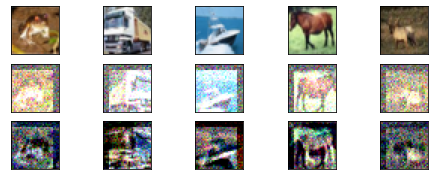

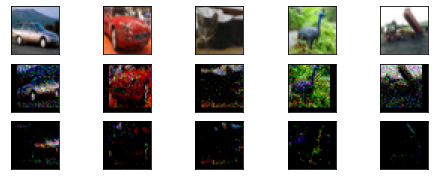

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
reload(utils)

def plot_one_img(img):
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)

def plot_images(im1, im2):
    plt.figure(figsize=(8, 3))
    for i in range(5):
        plt.subplot(3, 5, i+1)
        plot_one_img(im1[i])
        plt.subplot(3, 5, 5+i+1)
        plot_one_img(im2[i])
        plt.subplot(3, 5, 10+i+1)
        plot_one_img(im2[i] - im1[i])



for (im, idx), (uim, uidx) in zip (train_ds, unlabeled_ds):
    aug1, _ = utils._augment_fn(im, {}, adjust_colors=True)
    aug2, _ = utils._augment_fn(im, {}, adjust_colors=True, noise_sigma=0.15)
    plot_images(im, aug2)
        

In [5]:
import argparse
import train
import importlib
importlib.reload(train)

from train import Model
model_type = 'resnet18'
model = Model(model_type, 10)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


ImportError: cannot import name 'Model' from 'train' (/home/jovyan/semi_supervised/tf2-cifar/train.py)

In [ ]:
ckpt_path = f'./checkpoints/{model_type}/train_frac_{0.08}'
model.load_model_from_ckpt(ckpt_path)

In [ ]:
model.run_test(test_data)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,5)
for i in range(10):
    ax[i//5, i%5].imshow(test_images[i])
    plt.xticks([])
    plt.yticks([])
# test_images[:10].min(), test_images[:10].max()
